# Conditional Manatees

![manatees](ch8_pictures/manatees.png)

- Many manatees are hurt by propeller blades. $\Rightarrow$
To reduce the number of manatees injured by boats, 
we need to require propeller guards?

- Is up-armoring the damaged portions of returning A.W.38 bomber a good idea?

![plane](ch8_pictures/plane.png)

- A manatee struck by a keel is less likely to live than another grazed by a propeller.
- Bombers that returned home conspicuously lacked damage to the cockpit and engines. 

- **Conditioning** is one of the most important principles of statistical inference.
- Data are conditioning on how they enter into the sample.
- Posterior distributions are conditional on the data.
- All model-based inference is conditional on the model.
- Every inference is conditional on something, whether we notice it or not.

- Simple linear models frequently fail to provide enough conditioning.
- To model deeper conditionality—where the importance of one predictor depends upon
another predictor—we need **interaction** (also known as **moderation**).
- **Interaction** is a step toward GLM and multilevel models.

## 8.1 Building an interaction

<img src="ch8_pictures/africa.png" width="800">

- Africa 
  - 3 billion fewer people than Asia
  - as many languages as Asia
  - super genetically diverse

- Puzzle: Bad Geography is related to bad economies outside of Africa, 
but African economies may actually benefit from bad geography.

<img src="ch8_pictures/fig8_2.png" width="800">

- Is it because rugged regions of Africa were protected against slave raids?
  - Slave Trade has long-term bad effects on economic development.

- DAG
   - R: terrain ruggedness
   - G: GDP
   - C: continent
   - U: observed confounds (like distance to coast)

- DAG only says $G = f(R, C)$, but it doesn't say if and how R and C interact 
  
<img src="ch8_pictures/dag1.png" width="800">

- Why cannot we estimate Africa and the rest of the world separately?
  - The model says some parameters do not depend upon continent $\Rightarrow$ hurting the accuracy.
  - Isn't there uncertainty about the predictive value of distinguishing between continents?
  - We want to use information criteria to compare whether we treat all continents the same way?
  - It's good to borrow information across continents to reduce overfitting risk.

### Overthinking: Not so simple causation

- C: continent
- H: history
- R: terrain ruggedness
- G: GDP

<img src="ch8_pictures/dag2.png" width="800">

- Many possible causal paths
- If for example distance to coast is really what influenced H in the past,
-  not terrain ruggedness, then the association of terrain
ruggedness with GDP is non-causal. 
(since if $Cov(R, G) > 0$, we must have $Cov(R, H) > 0$)

### 8.1.1 Making a rugged model

In [1]:
using CSV
using Random
using StatsBase
using DataFrames
using Turing
using StatsPlots
using StatsFuns
using LaTeXStrings
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using ParetoSmoothedImportanceSampling
using Logging

default(labels=false)
Logging.disable_logging(Logging.Warn);

┌ Warning: Error requiring `Turing` from `StatisticalRethinking`
│   exception = (LoadError("/home/wendingliu/.julia/packages/StatisticalRethinking/MGUIA/src/require/turing/turing.jl", 4, LoadError("/home/wendingliu/.julia/packages/StatisticalRethinking/MGUIA/src/require/turing/turing_precis.jl", 14, UndefVarError(:DynamicPPL, StatisticalRethinking))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007f204dedfe7e, Ptr{Nothing} @0x00007f204de6fb32, Ptr{Nothing} @0x00007f204de70a6b, Ptr{Nothing} @0x00007f204de71afd, Base.InterpreterIP in top-level CodeInfo for StatisticalRethinking at statement 13, Ptr{Nothing} @0x00007f204de8e2ed, Ptr{Nothing} @0x00007f204de8ec39, Ptr{Nothing} @0x00007f204de8fca5, Ptr{Nothing} @0x00007f1fbc15f87b, Ptr{Nothing} @0x00007f202c50ae95, Ptr{Nothing} @0x00007f1fbc15f546, Ptr{Nothing} @0x00007f1fbc15f576, Ptr{Nothing} @0x00007f204de5f849, Ptr{Nothing} @0x00007f1f1c965db1, Ptr{Nothing} @0x00007f1f1c965e0e, Ptr{Nothing} @0x00007f204de70324, Ptr{Nothing

In [2]:
# 8.1
d = DataFrame(CSV.File("../data/rugged.csv"))
dd = d[completecases(d, :rgdppc_2000), :]
dd[:, :log_gdp] = log.(dd.rgdppc_2000);
# standardization: no z score since rugged = 0 is meaningful!
dd[:, :log_gdp_std] = dd.log_gdp / mean(dd.log_gdp)
dd[:, :rugged_std] = dd.rugged / maximum(dd.rugged);

Geocentric Skeleton
$$
log(y_i)  \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta (r_i - \bar{r}) \\
\alpha \sim Normal(1, 1) \\
\beta \sim Normal(0, 1) \\
\sigma \sim Exp(1)
$$

In [3]:
# 8.2
r̄ = mean(dd.rugged_std)

@model function model_m8_1(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 1)
    b ~ Normal(0, 1)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

model_m8_1 (generic function with 2 methods)

In [4]:
# 8.3
m8_1_p = sample(model_m8_1(dd.rugged_std, dd.log_gdp_std), Prior(), 1000)
m8_1_p_df = DataFrame(m8_1_p);

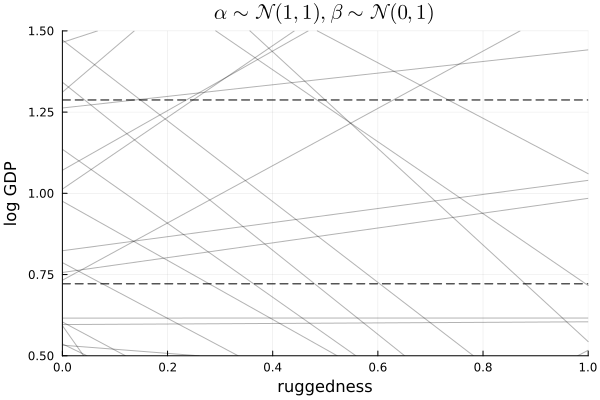

In [5]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_p_df, (r, x) -> r.a + r.b * (x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    xlim=(0, 1),
    ylim=(0.5, 1.5),
    title=L"\alpha \sim \mathcal{N}(1,1), \beta \sim \mathcal{N}(0, 1)",
    xlab="ruggedness", ylab="log GDP",
)
hline!(collect(extrema(dd.log_gdp_std)); c=:black, s=:dash)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p

- Too many extreme log GDP values $\Rightarrow$ tighten std of $\alpha$ prior
- More than half of the slopes have abs values > 0.6. It's hard to believe ruggedness can explain most of the variances of GDPs.

In [6]:
# 8.4
mean(abs.(m8_1_p_df.b) .> 0.6)

0.574

Let's change the priors
$$
log(y_i)  \sim Normal(\mu_i, \sigma) \\
\mu_i = \alpha + \beta (r_i - \bar{r}) \\
\alpha \sim Normal(1, 0.1) \\
\beta \sim Normal(0, 0.3) \\
\sigma \sim Exp(1)
$$

In [7]:
r̄ = mean(dd.rugged_std)

@model function model_m8_1a(rugged_std, log_gdp_std)
    σ ~ Exponential()
    a ~ Normal(1, 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_1 = sample(model_m8_1a(dd.rugged_std, dd.log_gdp_std), NUTS(), 1000)
m8_1_df = DataFrame(m8_1);

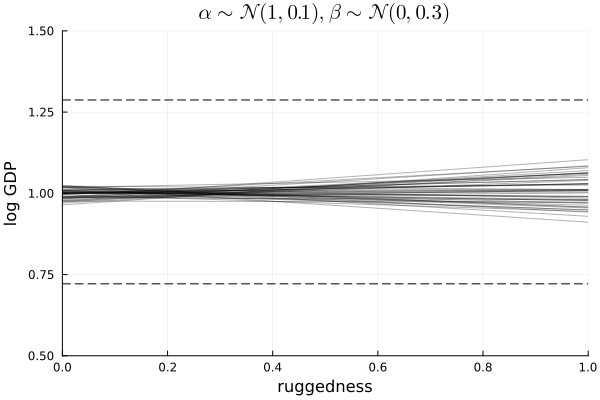

In [8]:
rugged_seq = range(-0.1, 1.1; length=30)
μ = link(m8_1_df, (r, x) -> r.a + r.b * (x - r̄), rugged_seq)
μ = hcat(μ...)

p = plot(
    xlim=(0, 1),
    ylim=(0.5, 1.5),
    title=L"\alpha \sim \mathcal{N}(1, 0.1), \beta \sim \mathcal{N}(0, 0.3)",
    xlab="ruggedness", ylab="log GDP",
)
hline!(collect(extrema(dd.log_gdp_std)); c=:black, s=:dash)
for μ₀ ∈ first(eachrow(μ), 50)
    plot!(rugged_seq, μ₀; c=:black, alpha=0.3)
end
p

In [9]:
# 8.6
precis(m8_1_df[!, [:a, :b, :σ]])

┌───────┬─────────────────────────────────────────────────────┐
│ param │   mean     std    5.5%     50%   94.5%    histogram │
├───────┼─────────────────────────────────────────────────────┤
│     a │ 1.0007  0.0104  0.9848  1.0006  1.0167   ▁▁▁▄██▄▁▁▁ │
│     b │ 0.0029  0.0563  -0.085  0.0039  0.0938     ▁▁▅██▅▂▁ │
│     σ │ 0.1385  0.0076  0.1265  0.1382  0.1512  ▁▁▃▆█▆▃▂▁▁▁ │
└───────┴─────────────────────────────────────────────────────┘


### Rethinking: Practicing for when it matters. 
- The model is simple enough, that even awful priors get
washed out. You could even use completely flat priors (don't!), and it would all be fine. 
- But we practice doing things right not because it always matters. 
- Rather, we practice doing things right so that we are ready when it matters. 
- No one would say that wearing a seat belt was a mistake, just because you
didn’t get into an accident

### 8.1.2 Adding an indicator variable isn't enough

- Using 0/1 dummy variable is Bad Practice
- $A_i$ : Africa = 1, Others = 0
- $\mu_i = \alpha + \beta(r_i − \bar{r}) + \gamma A_i$
- You need a prior for $\gamma$.
- That prior will necessarily do is tell the model that $\mu_i$
for a nation in Africa is more uncertain, before seeing the data, 
than $\mu_i$ outside Africa

- Simple solution
  $$\mu_i = \alpha_{CID[i]} + \beta(r_i - \bar{r})$$
- $CID[i] = 1$ if country $i$ is in Africa, 2 otherwise 

In [10]:
# 8.7
dd[:, :cid] = @. ifelse(dd.cont_africa == 1, 1, 2);

In [11]:
# 8.8
@model function model_m8_2(rugged_std, cid, log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ Normal(0, 0.3)
    μ = @. a[cid] + b * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_2 = sample(model_m8_2(dd.rugged_std, dd.cid, dd.log_gdp_std), NUTS(), 1000)
m8_2_df = DataFrame(m8_2);

In [12]:
# 8.9

# Compute log likelihoods for both models
fun = (r, (x, y)) -> normlogpdf(r.a + r.b * (x - r̄), r.σ, y)
m8_1_ll = link(m8_1_df, fun, zip(dd.rugged_std, dd.log_gdp_std))
m8_1_ll = hcat(m8_1_ll...)

# need DF with a as a vector of both a[1] and a[2]
df = DataFrame(m8_2_df)
df[!, :a] = collect.(zip(m8_2_df.:"a[1]", m8_2_df.:"a[2]"))

fun = (r, (x, c, y)) -> normlogpdf(r.a[c] + r.b * (x - r̄), r.σ, y)
m8_2_ll = link(df, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_2_ll = hcat(m8_2_ll...);

compare([m8_1_ll, m8_2_ll], :waic, mnames=["m8.1 (indicator)", "m8.2 (two intercepts)"])

Row,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.2 (two intercepts),-252.4,-260.59,14.83,0.0,0.0,4.08,1.0
2,m8.1 (indicator),-188.9,-194.01,12.91,63.5,14.68,2.54,0.0


- The WAIC of two $\alpha$ model is much lower than then indicator model.
- So the continent variable seems to be picking up some important
association in the sample.

In [13]:
# 8.10
precis(m8_2_df[:, ["a[1]", "a[2]", "b", "σ"]])

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%   94.5%      histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │  0.8803  0.0163   0.8549   0.8809  0.9049    ▁▁▁▃▆██▆▃▁▁ │
│  a[2] │  1.0489  0.0102   1.0332   1.0489  1.0651  ▁▁▁▃▆███▇▄▂▁▁ │
│     b │ -0.0466  0.0467  -0.1195  -0.0471  0.0289        ▁▃██▄▁▁ │
│     σ │  0.1141  0.0062   0.1046    0.114  0.1241      ▁▂▆██▄▁▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


- $\alpha[1]$ (Africa) is reliably lower than $\alpha[2]$ (Others) 

In [14]:
# 8.11
println("89% confidence interval of diff")
PI(map(r -> r[1] - r[2], df.a))

89% confidence interval of diff


2-element Vector{Float64}:
 -0.1992368304198128
 -0.13766368252242697

In [15]:
# 8.12
# plot the posterior prediction for m8_2
rugged_seq = range(-0.1, 1.1, length=30)
africa = link(df, (r, x) -> r.a[1] + r.b * (x - r̄), rugged_seq)
africa = hcat(africa...)'
not_africa = link(df, (r, x) -> r.a[2] + r.b * (x - r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

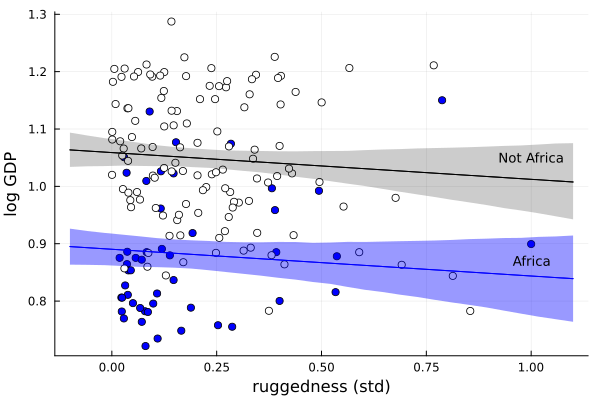

In [16]:
p = plot(xlab="ruggedness (std)", ylab="log GDP")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)

plot!(rugged_seq, [μₐ, μₐ], c=:blue, fillrange=PIₐ, fillalpha=0.4)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)
annotate!([
    (1, 0.87, ("Africa", 9)),
    (1, 1.05, ("Not Africa", 9))
])

- Despite its predictive superiority to m8.1, m8.2 still doesn't manage different slopes inside and outside of Africa
- The African nations do have lower overall economic development, and so the blue regression line
is below, but parallel to, the black line.
- All including a dummy variable for African nations
has done is allow the model to predict a lower mean for African nations. It can't do anything
to the slope of the line. 
- The fact that WAIC tells you that the model with the dummy variable (two $\alpha$)
is hugely better only indicates that African nations on average do have lower GDP.

### 8.1.3 Adding an interaction does work

- Model for $\mathbb{E}(log GDP)$ without interaction
$$
\mu_i=\alpha_{\mathrm{CID}[i]}+\beta\left(r_i-\bar{r}\right)
$$

- Double-down the indexing to make the slope conditional as well (1: Africa, 2: others)
$$
\mu_i=\alpha_{\mathrm{CID}[i]}+\beta_{\mathrm{CID}[i]}\left(r_i-\bar{r}\right)
$$

- Bad practice: 0-1 indicator $A_i$ for African countries
$$
\mu_i=\alpha_{\mathrm{CID}[i]}+(\beta + \gamma A_i)\left(r_i-\bar{r}\right)
$$

In [17]:
# 8.13
@model function model_m8_3(rugged_std, cid, log_gdp_std)
    σ ~ Exponential()
    a ~ MvNormal([1, 1], 0.1)
    b ~ MvNormal([0, 0], 0.3)
    μ = @. a[cid] + b[cid] * (rugged_std - r̄)
    log_gdp_std ~ MvNormal(μ, σ)
end

m8_3 = sample(model_m8_3(dd.rugged_std, dd.cid, dd.log_gdp_std), NUTS(), 1000)
m8_3_df = DataFrame(m8_3);

In [18]:
# 8.14
precis(m8_3_df[!, ["a[1]", "a[2]", "b[1]", "b[2]", "σ"]])

┌───────┬──────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%     histogram │
├───────┼──────────────────────────────────────────────────────────┤
│  a[1] │  0.8869  0.0155   0.8634   0.8863   0.9117  ▁▁▁▃▇█▆▅▂▁▁▁ │
│  a[2] │  1.0504    0.01   1.0349   1.0501   1.0667      ▁▁▃██▄▁▁ │
│  b[1] │  0.1338  0.0781   0.0073   0.1338   0.2612  ▁▁▂▃▆█▇▄▂▁▁▁ │
│  b[2] │ -0.1425  0.0528  -0.2286  -0.1416  -0.0583      ▁▁▃██▄▁▁ │
│     σ │  0.1114   0.006   0.1021   0.1112   0.1215     ▁▁▃▇█▅▂▁▁ │
└───────┴──────────────────────────────────────────────────────────┘


- You see, b[1] is positive now.
- How much would two slopes improve prediction?

In [19]:
# 8.15
df3 = DataFrame(m8_3_df)
df3[!, :a] = collect.(zip(m8_3_df.:"a[1]", m8_3_df.:"a[2]"))
df3[!, :b] = collect.(zip(m8_3_df.:"b[1]", m8_3_df.:"b[2]"))

fun = (r, (x, c, y)) -> normlogpdf(r.a[c] + r.b[c] * (x - r̄), r.σ, y)
m8_3_ll = link(df3, fun, zip(dd.rugged_std, dd.cid, dd.log_gdp_std))
m8_3_ll = hcat(m8_3_ll...);

compare([m8_1_ll, m8_2_ll, m8_3_ll], :psis, mnames=["m8.1", "m8.2", "m8.3"])

Row,models,PSIS,lppd,SE,dPSIS,dSE,pPSIS,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m8.3,-260.3,-269.18,14.55,0.0,0.0,4.76,0.97
2,m8.2,-253.0,-260.59,14.75,7.3,6.49,4.08,0.03
3,m8.1,-189.2,-194.01,12.89,71.1,14.86,2.54,0.0


- m8.3 has 97% weight → use it if you only care about prediction
- the modicum weight of m8.2 implies there might be some overfitting in m8.3
- dPSIS(m8.2 | m8.3) = 7.0, se = 6.46: maybe PSIS is not reliable
- PSIS also has some large Pareto k values
- maybe you should use Student-t regressions?
- **Prediction $\neq$ Causal Inference**

### 8.14 Plotting the interaction

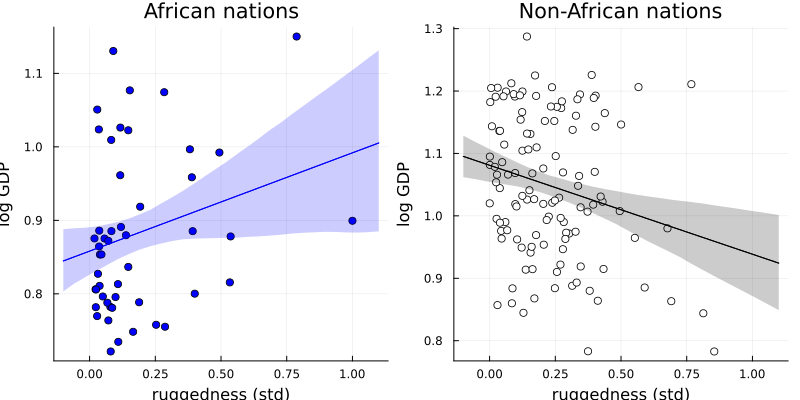

In [20]:
# build data
africa = link(df3, (r, x) -> r.a[1] + r.b[1] * (x - r̄), rugged_seq)
africa = hcat(africa...)'
not_africa = link(df3, (r, x) -> r.a[2] + r.b[2] * (x - r̄), rugged_seq)
not_africa = hcat(not_africa...)'

μₐ = mean.(eachrow(africa))
μₙ = mean.(eachrow(not_africa))
PIₐ = PI.(eachrow(africa))
PIₐ = vcat(PIₐ'...)
PIₙ = PI.(eachrow(not_africa))
PIₙ = vcat(PIₙ'...);

# plot Africa, cid=1
p1 = plot(xlab="ruggedness (std)", ylab="log GDP", title="African nations")
scatter!(dd.rugged_std[dd.cid.==1], dd.log_gdp_std[dd.cid.==1], c=:blue)
plot!(rugged_seq, [μₐ, μₐ], c=:blue, fillrange=PIₐ, fillalpha=0.2)

# plot non Africa, cid=2
p2 = plot(xlab="ruggedness (std)", ylab="log GDP", title="Non-African nations")
scatter!(dd.rugged_std[dd.cid.==2], dd.log_gdp_std[dd.cid.==2], c=:white)
plot!(rugged_seq, [μₙ, μₙ], c=:black, fillrange=PIₙ, fillalpha=0.2)

plot(p1, p2, size=(800, 400))

- The slope reverses direction inside and outside of Africa.
- We achieved this inside a **single** model, we could statistically evaluate the value
of this reversal.

## 8.2 Symmetry of interactions

<img src="ch8_pictures/ass.jpg" width="400">

- Buridan's ass : an ass who always moves towards
the closest pile of food will starve to death when he finds himself equidistant between two
identical piles.

- *Should two courses be judged equal, then the will cannot break the deadlock, all it can do is to suspend judgement until the circumstances change, and the right course of action is clear.*(Jean Buridan, c. 1340)

- The basic problem is one of symmetry.

- Of course the ass will not starve. But thinking about **how the symmetry is broken** can be productive.

- Interactions are like Buridan's ass: Like the two piles of identical food, a simple interaction model contains two symmetrical interpretations.

- You cannot say which interpretation is the "correct" one.

- Return to our regression, the interaction has two equally valid phrasings:
  - 1. How much does the association between ruggedness and log GDP depend upon
whether the nation is in Africa?
  - 2. How much does the association of Africa with log GDP depend upon ruggedness?

- While these two possibilities sound different to most humans, your golem thinks they are
identical.

Rewrite
$$
\mu_i=\alpha_{\mathrm{CID}[i]}+\beta_{\mathrm{CID}[i]}\left(r_i-\bar{r}\right)
$$
as
$$
\mu_i=\underbrace{\left(2-\operatorname{CID}_i\right)\left(\alpha_1+\beta_1\left(r_i-\bar{r}\right)\right)}_{\operatorname{CID}[i]=1}+\underbrace{\left(\operatorname{CID}_i-1\right)\left(\alpha_2+\beta_2\left(r_i-\bar{r}\right)\right)}_{\operatorname{CID}[i]=2}
$$


- Assume Australia is moved to Africa, while land quality remains the same. What's the expected GDP change?

- The equation above says: To calculate the difference, we need to know $r_i$, $i$ = Australia.

- Let's plot the *counterfactual*: we are seeing through the model’s eyes and imagining comparisons between identical nations inside and outside Africa, as if we could independently manipulate continent and also terrain ruggedness

In [21]:
# 8.18
rugged_seq = range(-0.2, 1.2, length=30)
μA = link(df3, (r, x) -> r.a[1] + r.b[1] * (x - r̄), rugged_seq)
μA = vcat(μA'...)
μN = link(df3, (r, x) -> r.a[2] + r.b[2] * (x - r̄), rugged_seq)
μN = vcat(μN'...)
delta = μA .- μN;

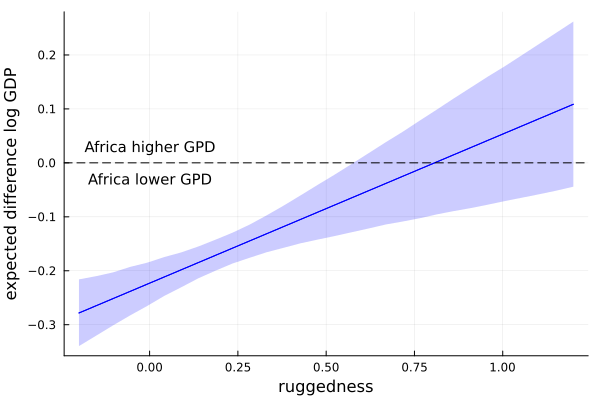

In [22]:
μ = mean.(eachrow(delta))
PI_v = PI.(eachrow(delta))
PI_v = vcat(PI_v'...)

plot(xlab="ruggedness", ylab="expected difference log GDP",)
plot!(rugged_seq, [μ, μ], c=:blue, fillrange=PI_v, fillalpha=0.2)
hline!([0.0], s=:dash, c=:black)
annotate!([
    (0.0, 0.03, ("Africa higher GPD", 10)),
    (0.0, -0.03, ("Africa lower GPD", 10)),
])

- In general, it is bad for GDP if a country is moved to Africa.
  
- But maybe it is good for country with super poor land. (Hard to say, std is too large.)

- Causal Interpretation
  -  Within the model, there's no basis to prefer one interpretation over the other, because in fact they are the
same interpretation. 

  - It's easy to imagine manipulating terrain ruggedness,
by flattening hills or blasting tunnels through mountains.

  - If in fact the explanation for
Africa’s unusually positive relationship with terrain ruggedness is due to historical causes,
not contemporary terrain, then tunnels might improve economies in the present.

  - At the same time, continent is not really a cause of economic activity. Rather there are historical
and political factors associated with continents, and we use the continent variable as a proxy
for those factors.

# 8.3 Continuous interactions

- We have learned that interaction effects are difficult to interpret.

- Once we start modeling interactions among continuous variables, it gets much harder.

- Use *triptych* plot to show the two-way interaction between two continuous variables.

### 8.3.1 A winter flower
<img src="ch8_pictures/tulip.png" width="400">

In [23]:
d = DataFrame(CSV.File("../data/tulips.csv"))
describe(d)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,bed,,a,,c,0,String1
2,water,2.0,1,2.0,3,0,Int64
3,shade,2.0,1,2.0,3,0,Int64
4,blooms,128.994,0.0,111.04,361.66,0,Float64


- Let's study how W: water (1:low, 2:medium, 3:high), S: shade (1:high light, 2:medium light, 3:low light) impact sizes of blooms

- Water and light work together for photosynthesis: interaction effect.

- Best model: use a theory of physiology to hypothesis a functional relationship.

- Good start: simple linear two-way interaction model.

### 8.3.2 The models


- DAG: $W \rightarrow B \leftarrow S$

- DAG doesn't tell us the function $f$ s.t. $B = f(W, S)$

- Only "main effects"
$$
\begin{aligned}
& B_i \sim \operatorname{Normal}\left(\mu_i, \sigma\right) \\
& \mu_i=\alpha+\beta_W\left(W_i-\bar{W}\right)+\beta_S\left(S_i-\bar{S}\right)
\end{aligned}
$$

In [24]:
# 8.20
d.blooms_std = d.blooms / maximum(d.blooms)
d.water_cent = d.water .- mean(d.water)
d.shade_cent = d.shade .- mean(d.shade);

NAIVE Priors:
$$
\begin{aligned}
\alpha & \sim \operatorname{Normal}(0.5,1) \\
\beta_W & \sim \operatorname{Normal}(0,1) \\
\beta_S & \sim \operatorname{Normal}(0,1)
\end{aligned}
$$

- $\alpha \sim \operatorname{Normal}(0.5,1)$: when both water and shade are at their mean
values, the model expects blooms to be halfway to the observed maximum

- $\beta_W$, $\beta_S$: You know nothing about botany but know the impacts cannot be arbitrarily large.

- Make the priors better: **the procedure of choosing priors force us to think about what the model means**

In [25]:
# 8.21
Random.seed!(1)
a = rand(Normal(0.5, 1), 10^4)
sum(@. (a < 0) | (a > 1)) / length(a) # we know α cannot be negative or larger than 1, the prior is too unrealistic!

0.6242

In [26]:
# 8.22
Random.seed!(1)
a = rand(Normal(0.5, 0.25), 10^4)
sum(@. (a < 0) | (a > 1)) / length(a) # much better!

0.0496

In [27]:
# 8.22_continue
# range of both W and S:  2
@show maximum(d.water_cent) - minimum(d.water_cent)
@show maximum(d.shade_cent) - minimum(d.shade_cent)
@show maximum(d.blooms_std) / 2.0 # slope = 0.5 can explain all the variations by only W or only S

maximum(d.water_cent) - minimum(d.water_cent) = 2.0
maximum(d.shade_cent) - minimum(d.shade_cent) = 2.0
maximum(d.blooms_std) / 2.0 = 0.5


0.5

In [ ]:
# 8.23 no interaction
@model function m8_4(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    μ = @. a + bw * water_cent + bs * shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_4_c = sample(m8_4(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_4_df = DataFrame(m8_4_c)
precis(m8_4_df[!, [:a, :bs, :bw, :σ]])

┌───────┬───────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%      histogram │
├───────┼───────────────────────────────────────────────────────────┤
│     a │  0.3574  0.0338   0.3051   0.3578   0.4114  ▁▁▁▁▄▆██▅▃▂▁▁ │
│    bs │ -0.1127    0.04  -0.1734  -0.1144  -0.0489        ▁▁▃█▆▁▁ │
│    bw │  0.2034  0.0398    0.139   0.2035   0.2657  ▁▁▂▄▆██▇▄▃▁▁▁ │
│     σ │  0.1761  0.0276   0.1369   0.1742   0.2248      ▁▂▇█▇▄▂▁▁ │
└───────┴───────────────────────────────────────────────────────────┘


- In the last example, we have two categories: Africa and Non-Africa
  
- Now we have infinite ordered categories for water and shade in principle (real number system)

- How to solve the problem? We use linear model recursively!

$$
\begin{aligned}
\mu_i & =\alpha+\gamma_{W, i} W_i+\beta_S S_i \\
\gamma_{W, i} & =\beta_W+\beta_{W S} S_i
\end{aligned}
$$

- The $i$ in $\gamma_{W, i}$ comes from the $i$ in $S_i$

- $\gamma_{W, i}$ is the slope defining how quickly blooms change with water level. 

- The parameter $\beta_W$ is the rate of change, when shade is at its mean value ($S_i = 0$). 
  
- $\beta_{W S}$ is the rate change in $\gamma_{W, i}$ as shade changes-the slope for shade on the slope of water. Remember, it's turtles all the way down. 

<img src="ch8_pictures/turtle.jpg" width="400">

- Plug in $\gamma_{W, i}$ into the first equation
$$
\mu_i=\alpha+\underbrace{\left(\beta_W+\beta_{W S} S_i\right)}_{\gamma_{W, i}} W_i+\beta_S S_i=\alpha+\beta_W W_i+\beta_S S_i+\beta_{W S} S_i W_i
$$

- Notice that if we denote $\gamma_{S, i} = \beta_{S} + \beta_{WS}W_i$, we get
$$
\begin{aligned}
\mu_i & =\alpha+\beta_W W_i+\gamma_{S, i} S_i \\
\gamma_{S, i} & =\beta_S+\beta_{S W} W_i
\end{aligned}
$$
where $\beta_{S W} := \beta_{W S}$. 
This makes the association of shade with blooms conditional on water!

- Why?
  - Ask Buridan's donkey.

- The interaction model:
$$
\begin{aligned}
& B_i \sim \operatorname{Normal}\left(\mu_i, \sigma\right) \\
& \mu_i=\alpha+\beta_W W_i+\beta_S S_i+\beta_{W S} W_i S_i
\end{aligned}
$$

- The only remaining task is to choose a prior for $\beta_{W S}$
 - Suppose the strongest plausible interaction is one in which high enough shade makes water
have zero effect.
$$
\gamma_{W, i}=\beta_w+\beta_{W S} S_i=0
$$
 - If we set $S_i=1$ (the maximum in the sample), then this means $\beta_{W S}=-\beta_W$. That is the largest conceivable interaction. 
 - So if we set the prior for $\beta_{W S}$ to have the same standard deviation as $\beta_W$, maybe that isn't ridiculous. 

In [ ]:
# 8.24 with interaction
@model function m8_5(water_cent, shade_cent, blooms_std)
    a ~ Normal(0.5, 0.25)
    bw ~ Normal(0, 0.25)
    bs ~ Normal(0, 0.25)
    bws ~ Normal(0, 0.25)
    μ = @. a + bw * water_cent + bs * shade_cent + bws * water_cent * shade_cent
    σ ~ Exponential(1)
    blooms_std ~ MvNormal(μ, σ)
end

m8_5_c = sample(m8_5(d.water_cent, d.shade_cent, d.blooms_std), NUTS(), 1000)
m8_5_df = DataFrame(m8_5_c)
precis(m8_5_df[!, [:a, :bs, :bw, :bws, :σ]])

┌───────┬────────────────────────────────────────────────────────────┐
│ param │    mean     std     5.5%      50%    94.5%       histogram │
├───────┼────────────────────────────────────────────────────────────┤
│     a │  0.3596  0.0271   0.3169   0.3587   0.4025     ▁▁▂▅██▅▂▁▁▁ │
│    bs │ -0.1138  0.0324  -0.1649  -0.1141  -0.0612     ▁▁▂▅▇█▆▄▂▁▁ │
│    bw │  0.2041  0.0352   0.1482   0.2054   0.2573  ▁▁▁▁▃▅▇█▆▄▂▁▁▁ │
│   bws │ -0.1429  0.0414  -0.2079  -0.1436  -0.0774          ▁▂▇█▃▁ │
│     σ │   0.143  0.0233     0.11   0.1409   0.1843       ▁▄██▄▂▁▁▁ │
└───────┴────────────────────────────────────────────────────────────┘


### 8.3.3 Plotting posterior predictions

- We can use **TRIPTYCH** to show the bivariate relationship between water and blooms,
  Each plot will plot predictions for a different value of shade.
  
- Choose a representative low value, median, and a representative high value of shade.

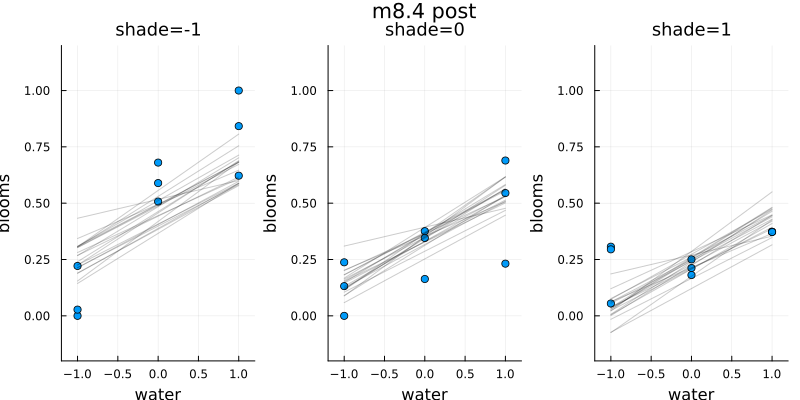

In [ ]:
# without interaction!
# light is good! but the slope is same for different shade level.

plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2, 1.2), ylims=(-0.2, 1.2), xlab="water", ylab="blooms",
        title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_4_df, (r, water) -> r.a + r.bw * water + r.bs * shade, water_seq)
    mu = hcat(mu...)
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.4 post", plot_titlefontsize=14)

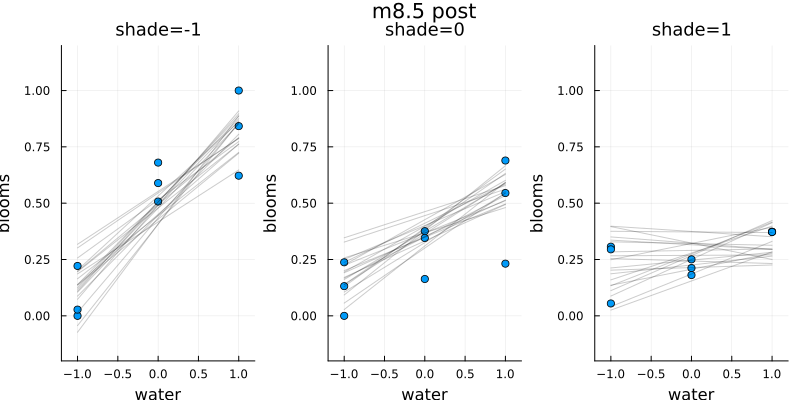

In [ ]:
# with interaction
# effect of water decreases as shade increases


plts = []

for shade ∈ -1:1
    idx = findall(==(shade), d.shade_cent)
    p = plot(xlims=(-1.2, 1.2), ylims=(-0.2, 1.2), xlab="water", ylab="blooms",
        title="shade=$shade", titlefontsize=12)
    scatter!(d.water_cent[idx], d.blooms_std[idx])
    water_seq = -1:1
    mu = link(m8_5_df, (r, water) -> r.a + r.bw * water + r.bs * shade + r.bws * water * shade, water_seq)
    mu = hcat(mu...)
    for μ ∈ first(eachrow(mu), 20)
        plot!(water_seq, μ, c=:black, alpha=0.2)
    end
    push!(plts, p)
end
plot(plts..., layout=(1, 3), size=(800, 400), plot_title="m8.5 post", plot_titlefontsize=14)

- Why effect of water decreases as shade increases?
  - Tulips need both water and light to produce blooms.
  - At low light levels, water can’t have much of an effect,
because the tulips don’t have enough light to produce blooms.
  - At higher light levels, water
can matter more, because the tulips have enough light to produce blooms.
  - At very high light
levels, light is no longer limiting the blooms, and so water can have a much more dramatic
impact on the outcome. 

## 8.4 Summary
- **Interactions** allow for the association between a predictor
and an outcome to depend upon the value of another predictor.

- While you can’t see them in
a DAG, interactions can be important for making accurate inferences. 

- Interactions can be difficult to interpret, and so the chapter also introduced triptych plots that help in visualizing
the effect of an interaction.

- To go any further, we're
going to need a more capable conditioning engine to fit our models to data: MCMC.